In [1]:
# general imports
import sys
sys.path.append('/home/tplas/repos/Vape/')
sys.path.append('/home/tplas/repos/Vape/utils')
sys.path.append('/home/tplas/repos/Vape/jupyter/')
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import utils_funcs as utils
import run_functions as rf
from subsets_analysis import Subsets
import pickle
import sklearn.decomposition
from dPCA import dPCA
from cycler import cycler
import seaborn as sns
plt.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette('colorblind'))

In [2]:
%run setup_notebook.ipynb

ERROR:root:File `'setup_notebook.ipynb.py'` not found.


In [3]:
## Load data
pkl_path = '/mnt/qnap_jrowland/run_pkls'


# dictionary of mice and run numbers to analyse
run_dict = {
            'J048' : [27, 29, 30, 32], 
            'RL048': [23, 24, 25, 28, 29]
           }

# local path to behaviour pickle files
# this takes a while to load so maybe should do some further caching in the future
# pkl_path = '/home/jamesrowland/Documents/Code/Vape/run_pkls/'

runs = []
mouse = 'J048'
run_number = 27
# for run_number in run_dict[mouse]:
print(f'Now loading mouse {mouse}, run {run_number}')
run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
with open(run_path, 'rb') as f:
    r = pickle.load(f)
    runs.append(r)

# runs = []
# for mouse in run_dict:
#     for run_number in run_dict[mouse]:
#         print(f'Now loading mouse {mouse}, run {run_number}')
#         run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
#         with open(run_path, 'rb') as f:
#             r = pickle.load(f)
#             runs.append(r)

Now loading mouse J048, run 27


This run has 2101 cells and 16117 frames


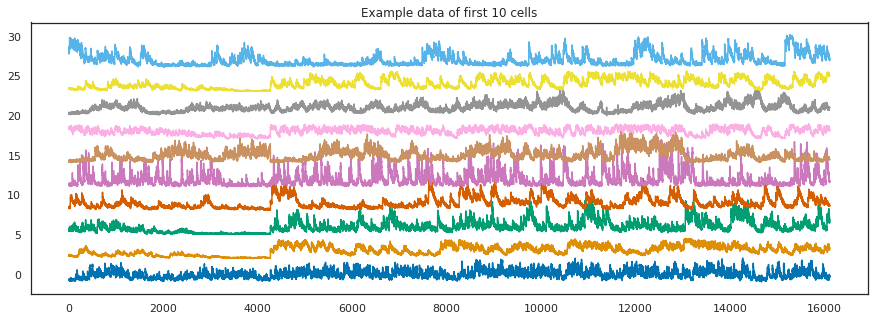

In [4]:
## Inspect data

# runs[0].__dict__.keys()

# processed (neuropil subtracted and Df/f) fluoresence matrix from first run
flu = runs[0].flu
print('This run has {} cells and {} frames'.format(flu.shape[0], flu.shape[1]))

# plot the first 10 cells in the first run
plt.figure(figsize=(15,5))
for i in range(10):
    plt.plot(flu[i,:] + i*3)
plt.title('Example data of first 10 cells')
# run objects have info from the suite2p stat (1xdictionary per cell
# used to e.g. find the plane each cell is in
plane0_idx = [idx for idx, s in enumerate(runs[0].stat) if s['iplane']==0]

# ## Find plane_0 neurons:
# # run objects have info from the suite2p stat (1xdictionary per cell
# # used to e.g. find the plane each cell is in
# plane0_idx = [idx for idx, s in enumerate(runs[0].stat) if s['iplane']==0]


# plt.rcParams['figure.figsize'] = (10, 10)
# plt.plot(galvo_ms / 1e6, trial_start[:] /1e6, '.-')
# print(run_number, mouse)
# # np.isnan(galvo_ms)
# runs[0].aligner.A_to_B
# -1
# trial_start.shape
# tstart_galvo.shape
# mouse, run_number

# runs[0].frames_ms.shape
# runs[0].flu.shape
# plt.imshow(np.isnan(runs[0].frames_ms))

In [5]:
## Align with  behaviour:
#### two timestamps for the onset of photostimulation ####

# when is voltage sent to the x photostimulation galvo
tstart_galvo = utils.threshold_detect(runs[0].x_galvo_uncaging, 0)

# when did the behaviour microcontroller trigger a trial start
trial_start = runs[0].trial_start
# if (run_number == 29 and mouse == 'J048') or (run_number == 29 and mouse == 'RL048'):
#     slope = (trial_start[-2] - trial_start[0]) / (tstart_galvo[-1] - tstart_galvo[0])
#     new_point = tstart_galvo[-1] + slope * (trial_start[-1] - trial_start[-2])
#     tstart_galvo = np.concatenate((tstart_galvo, new_point[np.newaxis]))

assert len(trial_start) == len(tstart_galvo)

#### these two timestamp variables are in a different reference frame ####

# run objects have an aligner method to switch between reference frames
galvo_ms = runs[0].aligner.B_to_A(tstart_galvo)

print('microcontroller trial starts occur on average {} ms from galvo trial starts'
      .format(round(np.mean(trial_start - galvo_ms), 2)))


assert runs[0].frames_ms.shape == runs[0].flu.shape

microcontroller trial starts occur on average -36.39 ms from galvo trial starts


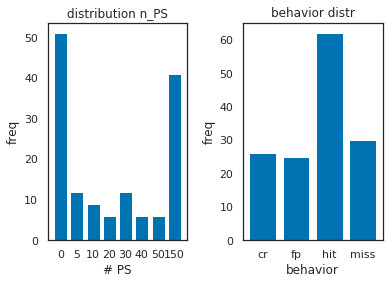

In [6]:
### a different number of cells were stimulated on each trial
### need to create a Subsets object to get this info (future code refinement will
### include this info directly in the run object
subsets = Subsets(runs[0])
trial_subsets = subsets.trial_subsets
# print(trial_subsets[5:20])
n_stim_arr = np.unique(trial_subsets)
plt.subplots_adjust(wspace=0.4)

plt.subplot(121)
plt.bar(np.arange(len(n_stim_arr)), height=[np.sum(trial_subsets == x) for x in n_stim_arr])
plt.xticks(np.arange(len(n_stim_arr)), (str(x) for x in n_stim_arr))
plt.xlabel("# PS"); plt.ylabel('freq'); plt.title('distribution n_PS')
### the result of the behavioural trial is in the run.oucome array

plt.subplot(122)
outcome = runs[0].outcome
outcome_arr = np.unique(outcome)
# print(outcome[5:20])
plt.bar(np.arange(len(outcome_arr)), height=[np.sum(outcome == x) for x in outcome_arr])
plt.xticks(np.arange(len(outcome_arr)), (str(x) for x in outcome_arr))
plt.xlabel('behavior'); plt.ylabel('freq'); plt.title('behavior distr')
assert len(runs[0].outcome) == len(tstart_galvo) == len(subsets.trial_subsets)


# licks = runs[0].session.times.get('lick_1')

Shape new array : (2101, 143, 42)
(2101, 143, 42) (2101, 8, 42)


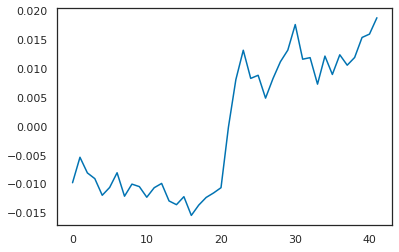

In [7]:
# the number of frames before trial start to take into array
pre_frames = 21
# the number of frames after trial start to take into array
post_frames = 21

art_gap_start = pre_frames - 1
art_gap_stop = pre_frames + 3
# array of fluoresence through behavioural trials (n_cells x n_trials x n_frames)
# with e.g. the first trials spanning (galvo_ms[0] - pre_frames) : (galvo_ms[0] + post_frames)
behaviour_trials = utils.build_flu_array(runs[0], galvo_ms, pre_frames, post_frames)
behaviour_trials = behaviour_trials - np.nanmean(behaviour_trials, (1, 2))[:, np.newaxis, np.newaxis]
print(f'Shape new array : {behaviour_trials.shape}')
assert behaviour_trials.shape[1] == outcome.shape[0]


pre_rew_trials = utils.build_flu_array(runs[0], runs[0].pre_reward, pre_frames, 
                                       pre_frames, is_prereward=True)  # equal amount b/c no PS artefact
pre_rew_trials = pre_rew_trials[:, 1:9, :]
assert np.sum(np.isnan(pre_rew_trials)) == 0
pre_rew_trials = pre_rew_trials - np.mean(pre_rew_trials, (1, 2))[:, np.newaxis, np.newaxis]
print(behaviour_trials.shape, pre_rew_trials.shape)
plt.plot(np.nanmean(pre_rew_trials, (0, 1)))

In [8]:
decision = np.logical_or(outcome == 'hit', outcome == 'fp').astype('int')
photostim = np.ones_like(trial_subsets)  # ones = 5-50
photostim[trial_subsets == 0] = 0
photostim[trial_subsets == 150] = 2
# unique_ps_numbers = np.unique(trial_subsets)
# assert unique_ps_numbers[0] == 0
# for i_n, n_ps in enumerate(unique_ps_numbers):
#     photostim[trial_subsets == n_ps] = i_n
assert photostim.shape == decision.shape
# np.random.shuffle(photostim)
# np.random.shuffle(decision)

n_unique_stims = len(np.unique(photostim))
n_neurons = behaviour_trials.shape[0]
n_times = behaviour_trials.shape[2]
n_trials = behaviour_trials.shape[1]
n_unique_dec = len(np.unique(decision))
occ_table = np.zeros((n_unique_stims, 2))  # stim x dec
for dec in range(n_unique_dec):
    for stim in range(n_unique_stims):
        occ_table[stim, dec] = np.sum(np.logical_and(decision == dec, photostim == stim))
n_com_trials = np.max(occ_table).astype('int')
print(occ_table)

[[26. 25.]
 [25. 26.]
 [ 5. 36.]]


(2101, 25, 42)
(2101, 17, 42)
(2101, 4, 42)
(2101, 25, 42)
(2101, 26, 42)
(2101, 33, 42)
(33, 2101, 2, 2, 38)


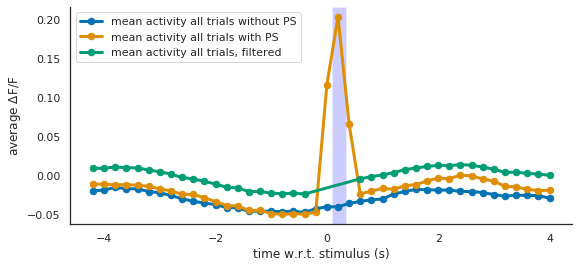

In [9]:
activity = np.zeros((n_com_trials, n_neurons, n_unique_stims, n_unique_dec, n_times))
activity = activity * np.nan
nan_trials = np.isnan(np.mean(behaviour_trials, (0, 2)))
min_common = 100
max_common = 0
for dec in range(n_unique_dec):
    for stim in range(n_unique_stims):
        inds_cond = np.logical_and(decision == dec, photostim == stim)
        inds_cond = np.logical_and(inds_cond, np.logical_not(nan_trials))
        current_data = np.squeeze(behaviour_trials[:, inds_cond, :])
#         print(current_data.shape)
        if np.sum(inds_cond) == 1:
            current_data = current_data[:, np.newaxis, :]
        n_curr_trials = current_data.shape[1]
#         if n_curr_trials == 1:
#             current_data = current
        activity[:n_curr_trials, :, stim, dec, :] = np.swapaxes(current_data, 0, 1)
        max_common = np.maximum(max_common, current_data.shape[1])
        min_common = np.minimum(min_common, current_data.shape[1])
        print(current_data.shape)
# n_com_trials = np.minimum(n_com_trials, min_common)
n_com_trials = np.minimum(n_com_trials, max_common)

activity = activity[:n_com_trials, :, :, :, :]
n_unique_stims = 2
activity = activity[:, :, :n_unique_stims, :, :]  # filter out PS = 150 trials
filter_ps_array = np.concatenate((np.arange(art_gap_start), 
                                  np.arange(art_gap_stop, pre_frames + post_frames)))  # filter out few frames around PS
old_act = activity.copy()
activity = activity[:, :, :, :, filter_ps_array]
activity = activity - np.nanmean(activity[:, :, :, :, :], (0, 2, 3, 4))[np.newaxis, :, np.newaxis, np.newaxis, np.newaxis]
# activity = activity / np.nanstd(activity[:, :, :, :, :], (0, 2, 3, 4))[np.newaxis, :, np.newaxis, np.newaxis, np.newaxis]
activity_av = np.nanmean(activity, 0)


plt.rcParams['figure.figsize'] = (9, 4)
im_freq = 5
plt.axvspan(xmin=0.1, xmax=0.35, 
            ymin=-0.05, ymax=1, facecolor='blue', alpha=0.2)
time_array_plot = (np.arange(old_act.shape[4]) - pre_frames) / im_freq
plt.plot(time_array_plot, np.nanmean(old_act, (0, 1, 3)).T[:, 0], '.-', label='mean activity all trials without PS', linewidth=3, markersize=13)
plt.plot(time_array_plot, np.nanmean(old_act, (0, 1, 3)).T[:, 1], '.-', label='mean activity all trials with PS', linewidth=3, markersize=13)
plt.plot((filter_ps_array - pre_frames) / im_freq, np.nanmean(activity, (0, 1, 2, 3)), '.-', label='mean activity all trials, filtered', markersize=13, linewidth=3)
plt.legend(); plt.xlabel('time w.r.t. stimulus (s)'); plt.ylabel('average $\Delta$F/F'); sns.despine()
print(activity.shape)


In [10]:
# plt.rcParams['figure.figsize'] = (9, 4)
# im_freq = 5

# fake_plot = {x: np.zeros_like(time_array_plot) for x in range(3)}
# fake_plot[0][22:24] = 1
# fake_plot[1][22:32] = np.exp(-0.5 * np.arange(10))
# fake_plot[2][22:40] = np.exp(-0.2 * np.arange(18))

# plt.axvspan(xmin=0.1, xmax=0.35, 
#             ymin=-0.05, ymax=1, facecolor='blue', alpha=0.2)
# plt.plot(time_array_plot, fake_plot[0], 'k', linewidth=2, label='regressor?')
# plt.plot(time_array_plot, fake_plot[1], 'k--', linewidth=3, label='or this regressor?')
# plt.plot(time_array_plot, fake_plot[2], 'k:', linewidth=3, label='or perhaps this regressor??')
# plt.xlim([time_array_plot[0], time_array_plot[-1]])
# plt.legend(); plt.xlabel('time w.r.t. stimulus (s)'); plt.ylabel('average $\Delta$F/F'); sns.despine()


In [11]:
dpca = dPCA.dPCA(labels='sdt', n_components=5, regularizer=0.001)
dpca.protect = ['t']

# activity = activity[:, inds_pos_r2, :, :, :]
# activity_av = activity_av[inds_pos_r2, :, :, :]
Z = dpca.fit_transform(activity_av, activity)
reg_param = dpca.regularizer

recon = {}
recon['st'] = (dpca.reconstruct(activity_av, marginalization='st').copy() +
               dpca.reconstruct(activity_av, marginalization='s').copy())
recon['dt'] = (dpca.reconstruct(activity_av, marginalization='dt').copy() +
               dpca.reconstruct(activity_av, marginalization='d').copy())
recon['sdt'] = (dpca.reconstruct(activity_av, marginalization='sdt').copy() +
               dpca.reconstruct(activity_av, marginalization='sd').copy())
recon['t'] = dpca.reconstruct(activity_av, marginalization='t').copy()
recon['full'] = np.zeros_like(recon['st'])
for cond in ['t', 'st', 'dt', 'sdt']:
    recon['full'] += recon[cond]
    
tmp = dpca.transform(activity_av, marginalization=None)  # call this function to recompute explained_variance_ratio_ (for something reason/buggy this is reset upon every marginalizaiton for all dimensions that are not the marginalization)
reg_param_str_sn = '{:.0e}'.format(dpca.regularizer)
save_fig = True

In [12]:
# Z['st'][0, 0, :, :] + Z['st'][0, 1, :, :]
# Z['dt'][0, :, 0, :] + Z['dt'][0, :, 1, :]

In [13]:
dec_color = {0: 'purple', 1: 'green'}
stim_alpha = {0: 0.3, 1: 0.7, 2: 1}
# stim_alpha = {n_x: x for n_x, x in enumerate(np.linspace(0.2, 1, len(unique_ps_numbers)))}
title_cond = {'t': 'condition indep.', 's': 'PS dependent',
              'd': 'lick dependent', 'sd': 'lick / PS interaction'}
label_cond = {#'stim': {n_x: str(x) for n_x, x in enumerate(unique_ps_numbers)},
                'stim': {0: 'no PS', 1: 'PS', 2: '150'}, 
              'dec': {0: 'no lick', 1: 'lick'}}
i_pc = 0  # what dPC to plot

def plot_condition(ax, cond, pc_plot=i_pc):
    """Function to plot 1 condition on axis object ax"""
    for dec in range(n_unique_dec):  # loop through all conditions
        for stim in range(n_unique_stims):
            plot_array = None
            plot_array = Z[cond][pc_plot, stim, dec, :].copy()  # data to plot
            expl_var = dpca.explained_variance_ratio_[cond][pc_plot].copy()  # extra 
            if cond != 't':
                plot_array += Z[cond + 't'][pc_plot, stim, dec, :].copy()
                expl_var += dpca.explained_variance_ratio_[cond + 't'][pc_plot].copy()
            ax.plot(filter_ps_array[:art_gap_start],
                    plot_array[:art_gap_start], label=f'{label_cond["stim"][stim]}, {label_cond["dec"][dec]}',
                     c=dec_color[dec], alpha=stim_alpha[stim], linewidth=2)
            ax.plot(filter_ps_array[art_gap_start:],
                    plot_array[art_gap_start:], #label=f'{label_cond["stim"][stim]}, {label_cond["dec"][dec]}',
                     c=dec_color[dec], alpha=stim_alpha[stim], linewidth=2)
#     if i_row == 1:
#         ax.set_xlabel('Time (frames)'); 
#     if i_col == 0:
#         ax.set_ylabel('Activity ($\Delta$F/F)'); 
    ax.set_title(title_cond[cond] + f' {pc_plot + 1}st dPC\n$R^2$: {np.round(expl_var * 100, 1)}%')
    if i_row == 0 and i_pc == 0:
#         ax.legend()
        ax.legend(bbox_to_anchor=(-1.45, 1.05), loc='upper left', 
                  borderaxespad=0., prop={'size': 15})
    data_1st_pc = Z[cond][0, :, :, :].copy()
#     print([np.min(data_1st_pc), np.max(data_1st_pc)])
    ax.set_ylim([-5, 5])
        

<Figure size 1008x720 with 0 Axes>

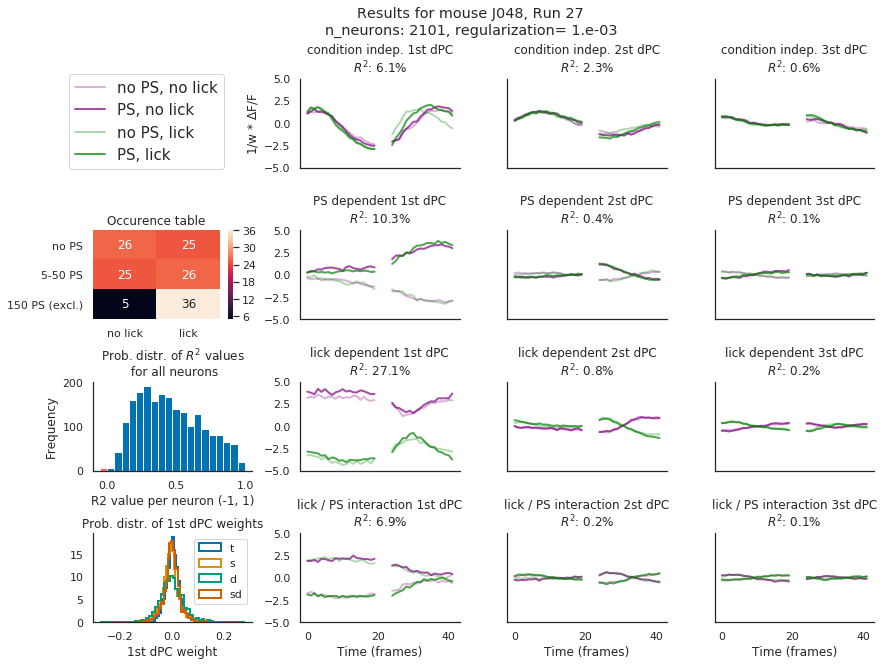

In [15]:

plt.rcParams['figure.figsize'] = (14, 10)
plt.subplots_adjust(hspace=0.6, wspace=0.4)
fig, axes = plt.subplots(4, 4, gridspec_kw={'wspace':0.3, 'hspace': 0.7})
save_fig = True
for i_row in range(4):
    for i_pc in range(3):
        plot_condition(axes[i_row][i_pc + 1], list(title_cond.keys())[i_row], pc_plot=i_pc)
        sns.despine()
        
axes[0][0].set_xticks([]); axes[0][0].set_yticks([])
axes[0][0].set_visible(False);
        
occ_heatmap = sns.heatmap(occ_table, annot=True, xticklabels=['no lick', 'lick'], 
            yticklabels=['no PS', '5-50 PS', '150 PS (excl.)'], ax=axes[1][0])
occ_heatmap.set_yticklabels(occ_heatmap.get_yticklabels(), rotation=0)
b, t = occ_heatmap.get_ylim() # correct for default cut off
b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
t -= 0.5 # 
axes[1][0].set_ylim(b, t) # update the ylim(bottom, top) values
axes[1][0].set_title('Occurence table')

r2_dpca =  1- (np.mean(np.power(activity_av - recon['full'], 2), (1, 2, 3)) /
            np.mean(np.power(activity_av - np.mean(activity_av, 3)[:, :,:, np.newaxis], 2), (1, 2, 3)))
axes[2][0].hist(r2_dpca, bins=np.linspace(0, 1, 20), density=False);
axes[2][0].hist(np.clip(r2_dpca, a_min=-0.03, a_max=0.001), bins=np.linspace(-0.05, -0.001, 2), 
                density=False, color='red', alpha=0.6);
axes[2][0].set_ylabel('Frequency')
axes[2][0].set_xlabel('R2 value per neuron (-1, 1)'); 
axes[2][0].set_title('Prob. distr. of $R^2$ values\n for all neurons')

axes[3][0].hist(dpca.D['t'][:, 0], bins=50, label='t',
        histtype='step', linewidth=2, density=True);
for cond in ['s', 'd', 'sd']:
    axes[3][0].hist((dpca.D[cond] + dpca.D[cond + 't'])[:, 0], bins=50, label=cond,
            histtype='step', linewidth=2, density=True);
axes[3][0].set_title(f'Prob. distr. of 1st dPC weights')
axes[3][0].legend(); axes[3][0].set_xlabel(f'1st dPC weight'); #plt.ylabel('PDF')

for i_row in range(3):
    for i_col in range(1, 4):
        axes[i_row][i_col].set_xticks([])
for i_row in range(4):
    for i_col in range(2, 4):
        axes[i_row][i_col].set_yticks([])
axes[0][1].set_ylabel('1/w * $\Delta$F/F')
for i_col in range(1, 4):
    axes[3][i_col].set_xlabel('Time (frames)')

plt.suptitle(f'Results for mouse {mouse}, Run {run_number}\n' \
             f'n_neurons: {activity.shape[1]}, regularization= ' +
             np.format_float_scientific(reg_param, precision=1));
if save_fig:
    plt.savefig(f'dPCA_results/dPCA_{mouse}_{run_number}_reg{reg_param_str_sn}.pdf') 
    save_fig = False

### use sklearn metric for automated variance weighing
### total r2? -> sum of individual r2 values?



In [16]:
def angle_vectors(v1, v2):
    v1, v2 = np.squeeze(v1), np.squeeze(v2)
    assert v1.shape == v2.shape
    rad = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    return rad * 360 / (2 * np.pi)

# angle_vectors(dpca.D['s'][:, 0] + dpca.D['st'][:, 0],
#              dpca.D['s'][:, 3] + dpca.D['st'][:, 3])

inds_pos_r2 = np.where(r2_dpca > 0.1)[0]
print(f'Fraction of R2 > 0 neurons: {np.round(inds_pos_r2.size / r2_dpca.size, 3)}')

total_abs_1st_w = np.zeros_like(dpca.D['t'][:, 0], dtype=np.float32)
for k in dpca.D.keys():
    total_abs_1st_w += np.abs(dpca.D[k][:, 0])
# sns.jointplot(total_abs_1st_w, r2_dpca, s=4)
# plt.ylim([-1, 1])
# np.arccos(0)

Fraction of R2 > 0 neurons: 0.978


In [17]:
import matplotlib
cm_norm = matplotlib.colors.Normalize(vmin=-0.1, vmax=0.1)
cm = matplotlib.cm.ScalarMappable(norm=cm_norm, cmap='PiYG')
tmp = cm.to_rgba(np.clip(w_pc_sd, a_min=-0.1, a_max=0.1))
tmp[:, 3] = np.abs(np.clip(w_pc_sd, a_min=-0.1, a_max=0.1)) ** 1.5
tmp[:, 3] = tmp[:, 3] / np.max(tmp[:, 3])

NameError: name 'w_pc_sd' is not defined

Text(0.5, 1.0, 'color = interaction')

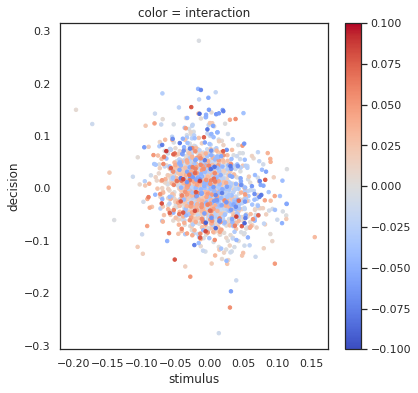

In [24]:
# print((dpca.D['s'] + dpca.D['st'])[:, 0].shape)

plt.rcParams['figure.figsize'] = (6, 6)
# inds_pos_r2 = np.where(r2_dpca > 0)[0]
# sns.jointplot((dpca.D['s'] + dpca.D['st'])[inds_pos_r2, 0],
#             (dpca.D['d'] + dpca.D['dt'])[inds_pos_r2, 0], s=6)

def scale_arr_01(arr):
    arr = np.squeeze(arr)
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

w_pc_s = (dpca.D['s'] + dpca.D['st'])[inds_pos_r2, 0]
w_pc_d = (dpca.D['d'] + dpca.D['dt'])[inds_pos_r2, 0]
w_pc_sd = ((dpca.D['sd'] + dpca.D['sdt'])[inds_pos_r2, 0])

plt.rcParams['figure.figsize'] = (6, 6)
plt.subplots_adjust(wspace=0.5)
# plt.subplot(121)
prev_al = 0
for i_al, al in enumerate(np.arange(0.01, 0.1, 0.01)):
    if al == 0.1:
        sub_inds = np.where(np.abs(w_pc_sd) >= prev_al)[0]
    else:
        sub_inds = np.where(np.logical_and(np.abs(w_pc_sd) < al, 
                                      np.abs(w_pc_sd) >= prev_al))[0]
    curr_alpha = (al * 10) ** 1.5
    prev_al = al
    plt.scatter(w_pc_s[sub_inds], w_pc_d[sub_inds], c=w_pc_sd[sub_inds],
                 s=12, cmap='coolwarm', vmin=-0.1, vmax=0.1)#, alpha=curr_alpha);
plt.colorbar(); plt.xlabel('stimulus');plt.ylabel('decision');
plt.title('color = interaction')

# plt.subplot(122)
# sns.regplot(w_pc_s + w_pc_d, w_pc_sd, scatter_kws={'s': 8})
# plt.xlabel('stimulus + decision'); plt.ylabel('interaction');

array([696])

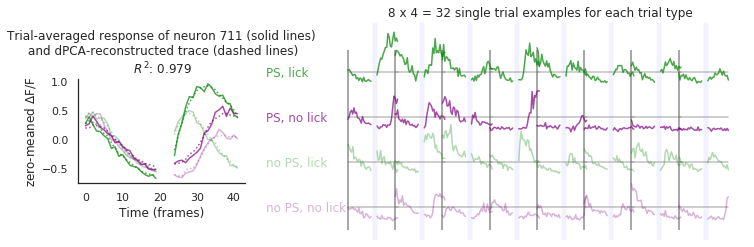

In [34]:
save_fig = True
select_new = False
plt.rcParams['figure.figsize'] = (12, 4)
if select_new:
    # neuron_ids = inds_pos_r2[np.where(w_pc_sd < -0.1)[0]]  # lick, no ps
    neuron_ids = np.where(r2_dpca > 0.9)[0]
    save_fig = False
    if len(neuron_ids) == 1:
        neuron_id = neuron_ids[0]
    else:
        print(f'There are {len(neuron_ids)} neurons that confirm')
        neuron_id = np.random.choice(neuron_ids, size=1)[0]
neuron_id = 711
        
        
plt.subplots_adjust(wspace=0.5)
plt.subplot(4, 3, (4, 7))
for stim in [0, 1]:
    for dec in [0, 1]:
        plt.plot(filter_ps_array[:art_gap_start], activity_av[neuron_id, stim, dec, :art_gap_start], 
                 label=f'stim{stim}_dec{dec}', c=dec_color[dec], alpha=stim_alpha[stim])
        plt.plot(filter_ps_array[:art_gap_start], recon['full'][neuron_id, stim, dec, :art_gap_start], 
                 c=dec_color[dec], alpha=stim_alpha[stim], linestyle=':')
        
        plt.plot(filter_ps_array[art_gap_start:], activity_av[neuron_id, stim, dec, art_gap_start:], 
                 c=dec_color[dec], alpha=stim_alpha[stim])
        plt.plot(filter_ps_array[art_gap_start:], recon['full'][neuron_id, stim, dec, art_gap_start:], 
                 c=dec_color[dec], alpha=stim_alpha[stim], linestyle=':')
        
# plt.legend(); 
plt.xlabel('Time (frames)'); plt.ylabel('zero-meaned $\Delta$F/F')
plt.title(f'Trial-averaged response of neuron {neuron_id} (solid lines)' +
          f'\n and dPCA-reconstructed trace (dashed lines)' +
            f'\n $R^2$: {np.round(r2_dpca[neuron_id], 3)}')

st_plot = plt.subplot(1, 3, (2, 3))
plot_y_shift = 4 * np.nanstd(activity[:, neuron_id, :, :, :])
n_examples = 8
start_example = 5
for n_example in range(start_example, start_example + n_examples):
    y_shift = 0
    x_shift = (len(filter_ps_array) + 1) * n_example
    for stim in [0, 1]:
        for dec in [0, 1]:
            st_plot.plot(filter_ps_array[np.array([0, -1])] + x_shift, 
                     [y_shift, y_shift], color='grey', alpha=0.5)
            st_plot.plot(filter_ps_array[:art_gap_start] + x_shift, 
                     activity[n_example, neuron_id, stim, dec, :art_gap_start] + y_shift, 
                     c=dec_color[dec], alpha=stim_alpha[stim])
            st_plot.plot(filter_ps_array[art_gap_start:] + x_shift, 
                     activity[n_example, neuron_id, stim, dec, art_gap_start:] + y_shift, 
                     c=dec_color[dec], alpha=stim_alpha[stim])
            y_shift += plot_y_shift
            if n_example == start_example:
                plt.text(s=f'{label_cond["stim"][stim]}, {label_cond["dec"][dec]}', 
                         y=y_shift - (plot_y_shift * 4 * 0.27), x=x_shift - 68, color=dec_color[dec], alpha=stim_alpha[stim])
    st_plot.vlines(x=x_shift, ymax= 3.5 * plot_y_shift, ymin= -0.5 * plot_y_shift, alpha=0.5)
    st_plot.axvspan(art_gap_start + x_shift, art_gap_stop + x_shift,
                facecolor='blue', alpha=0.05)
st_plot.set_title(f' {n_examples} x 4 = {n_examples * 4} single trial examples for each trial type'); 
# plt.xlabel('Time (frames)')
st_plot.set_yticks([]); st_plot.set_xticks([])
st_plot.axis('off')
sns.despine()

if save_fig:
    plt.savefig(f'dPCA_results/single_neuron_examples/dPCA_{mouse}_{run_number}_reg{reg_param_str_sn}_neuron{neuron_id}.pdf') 

In [35]:
neuron_id_r2inds = np.where(inds_pos_r2 == 711)[0]
print(w_pc_d[neuron_id_r2inds], w_pc_s[neuron_id_r2inds], w_pc_sd[neuron_id_r2inds])

[0.13101239] [0.02988911] [0.04239347]


## Does dimensionality change pre vs post stimulus?

In [65]:
dpca_rew, Z_rew = {}, {}
n_comps = 10
pre_rew_trials_half, pre_rew_trials_half_av = {}, {}
assert pre_rew_trials.shape[2] == (2 * pre_frames)
# pre_rew_trials_half['pre'] = np.swapaxes(pre_rew_trials[:, :, :pre_frames], 0, 1)
# pre_rew_trials_half['post'] = np.swapaxes(pre_rew_trials[:, :, pre_frames:], 0, 1)
# pre_rew_trials_half['full'] = np.swapaxes(pre_rew_trials[:, :, :], 0, 1)
pre_rew_trials_half['pre'] = activity[:, :, 0, 1, :art_gap_start]
pre_rew_trials_half['post'] = activity[:, :, 0, 1, art_gap_start:]
pre_rew_trials_half['full'] = activity[:, :, 0, 1, :]
for rewc in pre_rew_trials_half.keys():
    pre_rew_trials_half_av[rewc] = np.nanmean(pre_rew_trials_half[rewc], 0)
    dpca_rew[rewc] = dPCA.dPCA(labels='t', n_components=n_comps, 
                               regularizer=0)  # 0.5 / pre_rew_trials_half[rewc].shape[2])
    dpca_rew[rewc].protect = ['t']
    Z_rew[rewc] = dpca_rew[rewc].fit_transform(pre_rew_trials_half_av[rewc], 
                                               pre_rew_trials_half[rewc])

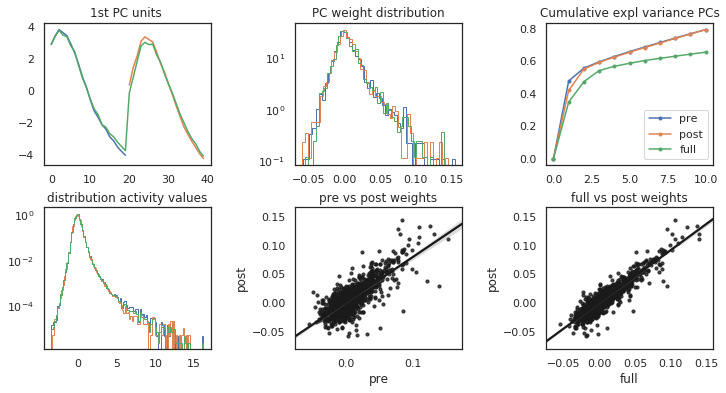

In [66]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.subplots_adjust(wspace=0.5, hspace=0.3)
for rewc in pre_rew_trials_half.keys():
    plt.subplot(231)
    tmp_x_arr = np.arange(len(Z_rew[rewc]['t'][0, :]))
    if rewc == 'post':
        tmp_x_arr += len(Z_rew['pre']['t'][0, :])
    plt.plot(tmp_x_arr, Z_rew[rewc]['t'][0, :], 
             label=rewc + f' $R^2$={np.round(dpca_rew[rewc].explained_variance_ratio_["t"][0], 3)}')
    plt.title('1st PC units ')
    
    
    plt.subplot(232)
    plt.hist(dpca_rew[rewc].D['t'][:, 0], bins=50, density=True, histtype='step', label=rewc)
    plt.yscale('log'); plt.title('PC weight distribution')
    
    plt.subplot(233)
    plt.plot(np.arange(0, n_comps + 1), np.concatenate((np.array([0]), np.cumsum(dpca_rew[rewc].explained_variance_ratio_['t']))),
             '.-', label=rewc)
#     plt.ylim([0, .5]);
    plt.title('Cumulative expl variance PCs')
    plt.legend()
    
    plt.subplot(234)
    plt.hist(pre_rew_trials_half[rewc].reshape(-1), bins=100, density=True, histtype='step')
    plt.title('distribution activity values')
    plt.yscale('log')

plt.subplot(235)
sns.regplot(dpca_rew['pre'].D['t'][:, 0], dpca_rew['post'].D['t'][:, 0], color='k', scatter_kws={'s': 10})
plt.title('pre vs post weights'); plt.xlabel('pre'); plt.ylabel('post')


plt.subplot(236)
sns.regplot(dpca_rew['full'].D['t'][:, 0], dpca_rew['post'].D['t'][:, 0], color='k', scatter_kws={'s': 10})
plt.title('full vs post weights'); plt.xlabel('full'); plt.ylabel('post');

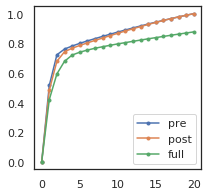

In [67]:
plt.rcParams['figure.figsize'] = (3, 3)

for regw in ['pre', 'post', 'full']:
    pca = sklearn.decomposition.PCA(n_components=20)
    pc = pca.fit_transform(pre_rew_trials_half_av[regw])
#     plt.plot(pca.components_[0, :].T)
    plt.plot(np.cumsum(np.concatenate((np.array([0]), 
                             pca.explained_variance_ratio_.copy()))), '.-', label=regw)
    plt.legend()
    